In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

In [2]:
processed_data = joblib.load('../../data/processed/processed_data_v2.joblib')
X_train = processed_data['X_train']
X_test = processed_data['X_test']
y_train = processed_data['y_train']
y_test = processed_data['y_test']
feature_names = processed_data['feature_names']
target_names = processed_data['target_names']

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Number of classes: {len(target_names)}")

Training set shape: (3936, 262)
Test set shape: (984, 262)
Number of features: 262
Number of classes: 41


In [3]:
# Define base models with adjusted parameters
log_reg = LogisticRegression(
    C=0.01,  # Increased regularization
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,  # Limit depth to prevent overfitting
    min_samples_split=5,  # Require more samples to split
    min_samples_leaf=2,  # Require more samples in leaf nodes
    class_weight='balanced',
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,  # Limit depth
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2,  # Increase to reduce overfitting
    random_state=42
)

# Create voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_reg),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft',
    weights=[1, 2, 2]  # Give more weight to tree-based models
)


In [4]:
# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation scores for individual models:")
for name, model in [('Logistic Regression', log_reg), 
                   ('Random Forest', rf), 
                   ('XGBoost', xgb)]:
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"\n{name}:")
    print(f"Scores: {scores}")
 

Cross-validation scores for individual models:

Logistic Regression:
Scores: [1. 1. 1. 1. 1.]

Random Forest:
Scores: [0.99746193 0.99872935 1.         0.9974587  1.        ]

XGBoost:
Scores: [1. 1. 1. 1. 1.]



Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.00      1.00      1.00        24
   

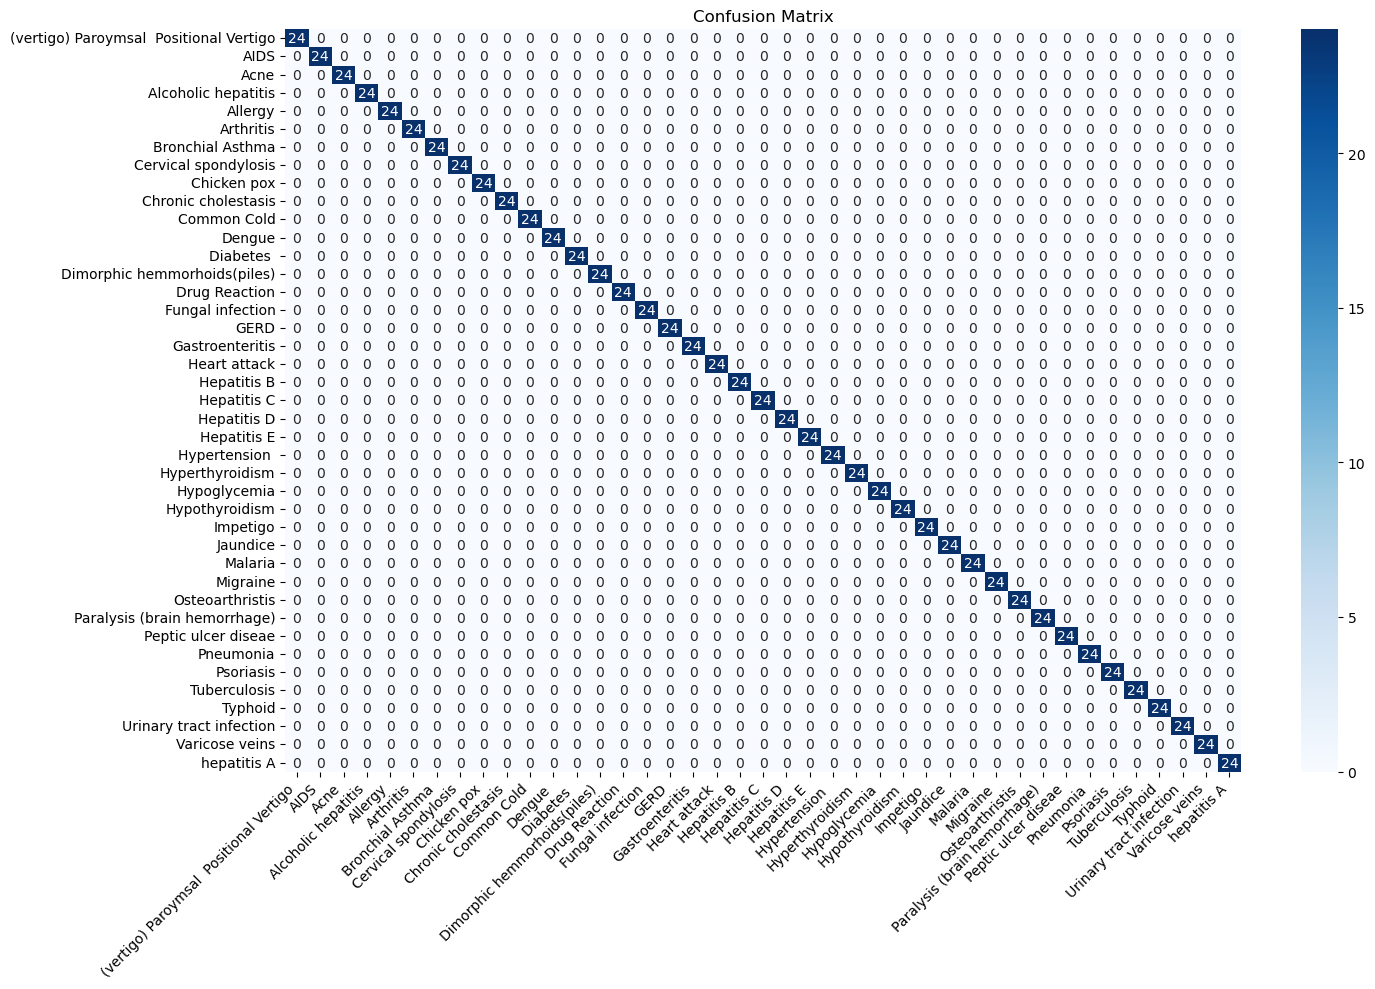

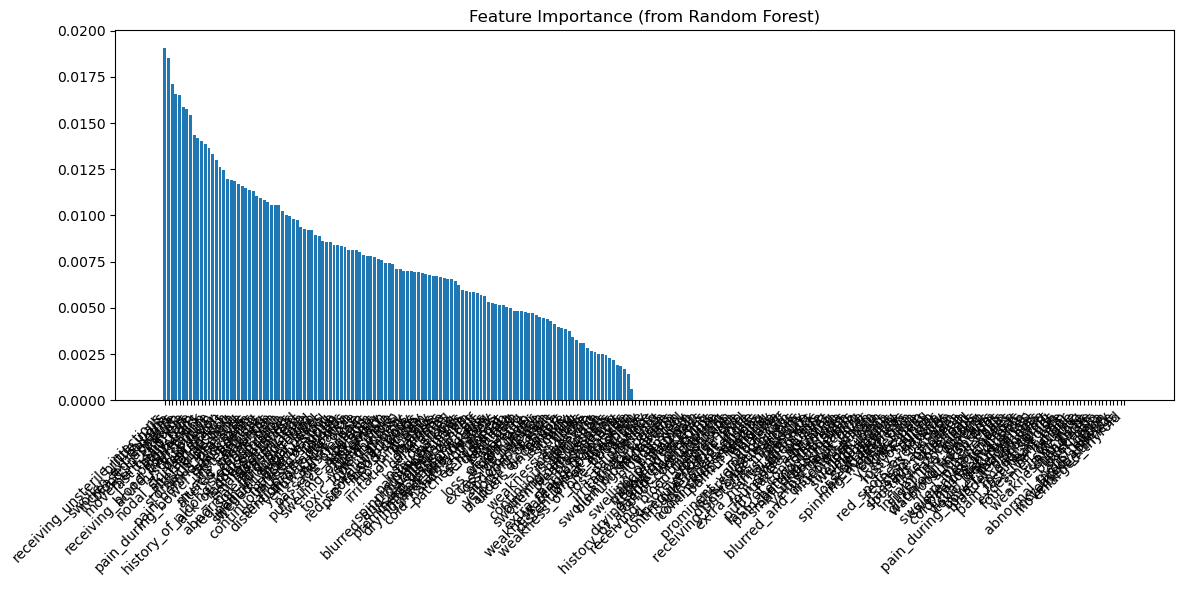


Top 10 most important features:
                            feature  importance
173  receiving_unsterile_injections    0.019061
28                    brittle_nails    0.018541
114                        polyuria    0.017092
142             swollen_extremeties    0.016549
174              increased_appetite    0.016502
219                 blood_in_sputum    0.015849
193                            coma    0.015746
163              movement_stiffness    0.015409
182                 fast_heart_rate    0.014360
68                       belly_pain    0.014170


In [5]:
# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(15, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Get feature importance from Random Forest
rf.fit(X_train, y_train)  # Fit RF separately for feature importance
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
})

# Sort features by importance
rf_importance = rf_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(rf_importance)), rf_importance['importance'])
plt.xticks(range(len(rf_importance)), rf_importance['feature'], rotation=45, ha='right')
plt.title('Feature Importance (from Random Forest)')
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\nTop 10 most important features:")
print(rf_importance.head(10))

In [6]:
# Save the model
model_data = {
    'voting_classifier': voting_clf,
    'feature_names': feature_names,
    'target_names': target_names
}
joblib.dump(model_data, '../../models/ensemble_models_v2.joblib')
print("\nModel saved successfully!")


Model saved successfully!


In [2]:
import pandas as pd

# Load the dataset
dataset_file = '../../data/raw/dataset.csv'
dataset = pd.read_csv(dataset_file)

# Define X (features) and y (target variable)
X = dataset.drop(columns=['Disease'])  # Features: all columns except the target
y = dataset['Disease']  # Target: Disease column
# Identify categorical columns in the dataset
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']


In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Label Encoding for target variable
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

# Binary Encoding for features (you can replace with One-Hot Encoding or Label Encoding if preferred)
import category_encoders as ce
binary_encoder = ce.BinaryEncoder(cols=categorical_cols)
X_encoded = binary_encoder.fit_transform(X)

# Splitting the data again after encoding
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Defining the models to use in the soft voting ensemble
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(probability=True, random_state=42)
nb_model = GaussianNB()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Creating the soft voting ensemble
voting_ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('svm', svm_model),
        ('nb', nb_model),
        ('xgb', xgb_model),
        ('lr', lr_model)  # Adding Logistic Regression to the ensemble
    ],
    voting='soft'  # Soft voting based on class probabilities
)

# Train the ensemble model
voting_ensemble.fit(X_train, y_train)

# Predict on the test set
y_pred_ensemble = voting_ensemble.predict(X_test)

# Evaluate the ensemble model
from sklearn.metrics import accuracy_score, classification_report

accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
report_ensemble = classification_report(y_test, y_pred_ensemble, output_dict=True)

# Print results
print(f"Ensemble Model Accuracy: {accuracy_ensemble}")
print("Classification Report:")
print(report_ensemble)


d:\Download\Anaconda\anaconda3\envs\conda_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble Model Accuracy: 1.0
Classification Report:
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 18.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 30.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 24.0}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 25.0}, '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 24.0}, '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23.0}, '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 33.0}, '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23.0}, '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21.0}, '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15.0}, '10': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23.0}, '11': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 26.0}, '12': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
dataset_file = '../../data/raw/dataset.csv'
dataset = pd.read_csv(dataset_file)

# Define X (features) and y (target variable)
X = dataset.drop(columns=['Disease'])
y = dataset['Disease']

# Identify categorical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']

# Label Encoding for categorical features
label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

# Label Encoding for target variable (Disease column)
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create and train the SVM model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

# Print results
print(f"SVM Model Accuracy: {accuracy_svm}")
print("Classification Report:")
print(report_svm)


SVM Model Accuracy: 0.9695121951219512
Classification Report:
{'0': {'precision': 0.9, 'recall': 1.0, 'f1-score': 0.9473684210526315, 'support': 18.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 30.0}, '2': {'precision': 0.8695652173913043, 'recall': 0.8333333333333334, 'f1-score': 0.851063829787234, 'support': 24.0}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 25.0}, '4': {'precision': 0.92, 'recall': 0.9583333333333334, 'f1-score': 0.9387755102040817, 'support': 24.0}, '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23.0}, '6': {'precision': 1.0, 'recall': 0.9696969696969697, 'f1-score': 0.9846153846153847, 'support': 33.0}, '7': {'precision': 1.0, 'recall': 0.8695652173913043, 'f1-score': 0.9302325581395349, 'support': 23.0}, '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21.0}, '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15.0}, '10': {'precision': 1.0, 'recall': 1.0, 'f1-sco